## Overall problem definition 
Find a way to calculate the global min/max of a function that handles local extrema robustly at scale.

## Overall approach explanation - 
Stochastic gradient descent works well, but not when there are many local extrema.  Instead of trying to work around those local extrema, what if we could make them vanish, with the global extremum vanishing last?

You can find various incomplete brainstorms below, titled by large headings

### The algorithm at work
Once we've reached a point where the morphing process eliminated all extremum but one (or all of them, in the case of a morphing into hyper-plane -- more on that later), run the transformation backwards, so that little-by-little (i.e. iteratively), extrema start to reappear.  The first extremum to reappear is the global extremum.  Use its position from the previous iteration of the inverse transformation as the starting point for gradient descent.  This will always keep us close to the previous iteration's global extremum, which we will follow all the way to the completely unmorphed function.

Solving this problem would rely on answers to these two questions

- How can we slowly morph our graph so that extrema disappear by modifying the equation?
- How can we do guarantee that the global extremum is the last to vanish / be squished?

### Clarification questions - 

1. What is meant by “vanishing”?  In the simplest sense, this means that the function is modified such that no peak or valley emerges.  In more detail, this means that the first derivative never crosses the x axis in 2D.  What does this mean in N-dimensions?  What else can we say about this process?
    
2. Is it even possible to modify a function such that a certain extremum will vanish?  We don’t know the coordinates or the value of the extrema, so this process would have to somehow rely on a global property of continuous (or perhaps restrict to polynomial?) functions and their extrema.  What such properties might exist?


To help visualize this idea, let's look at a function with multiple extrema, the Rastrigin function.

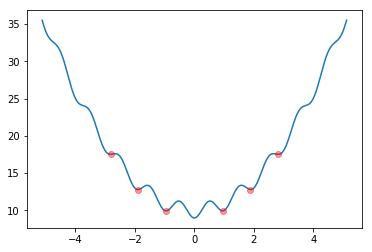

In [3]:
import numpy as np
from matplotlib.animation import FuncAnimation
from scipy.signal import argrelextrema
from scipy.fftpack import fft, ifft, fftshift

import matplotlib.pyplot as plt

A = 10
x = np.linspace(-5.12, 5.12, 400)
y = A + x**2 - np.cos(2*np.pi*x)
minima = argrelextrema(y, np.less)

plt.plot(x, y)
plt.plot(x[minima], y[minima], 'ro', alpha=.4)
plt.show()



The local minima are marked with the semi-transparent red circles.  The global minimum at the bottom is not marked, since we don't want that to vanish until all the local minima have vanished.  We can certainly change the function so that it has fewer extrema, such as by changing the frequency:

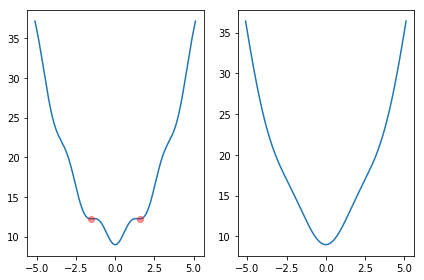

In [4]:
# Use a lower frequency so that we have fewer extrema
y = A + x**2 - np.cos(np.pi*x)
minima = argrelextrema(y, np.less)

plt.subplot(1, 2, 1)
plt.plot(x, y)
plt.plot(x[minima], y[minima], 'ro', alpha=.4)

# Use an lower frequency so that we have even fewer extrema 
# (just the global one, in this case)
y = A + x**2 - np.cos(np.pi/2 * x)
minima = argrelextrema(y, np.less)

plt.subplot(1, 2, 2)
plt.plot(x, y)
plt.plot(x[minima], y[minima], 'ro', alpha=.4)
plt.tight_layout()
plt.show()


But this is probably not generalizable, given that we are changing the frequency property of the cosine function.  Most functions don't have a frequency.  But what if we could change every function into a function that has frequency - via the FFT for example.  

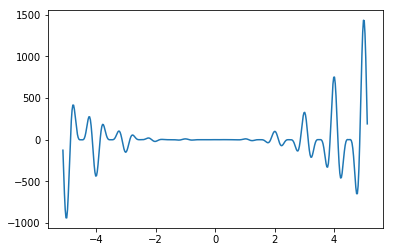

In [5]:
# Complicated function
y = (3 * np.cos(1 * 2*np.pi*x) + 5*np.cos(2 * 2*np.pi*x) + 2 * np.cos(3 * 2*np.pi*x)) * (x**3 + x**2 - x)
plt.plot(x, y)
plt.show()

[-4.65804511 -3.83679198 -2.83588972 -1.86065163 -1.0393985  -0.21814536
  0.60310777  1.39869674  2.37393484  3.37483709  4.42706767]
[ 11.97091019  -6.03632769  -3.0463725    0.28268026   1.6749563
   1.26635672   1.68343464   0.0435755   -4.23708703 -10.21773425
 -17.58363617]


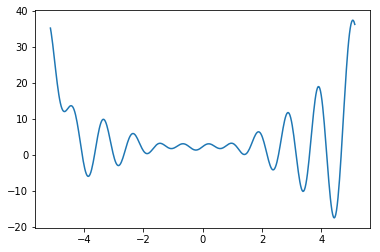

In [39]:
y_fft = fft(y)
half_length = int(len(y_fft) / 2)
scale_window = 12
scale = np.zeros(len(y_fft))
scale[0:scale_window] = 1 -  np.array(range(0, scale_window)) / scale_window

y_fft = y_fft * scale
y_fft[half_length:len(y_fft)] = 0
y_ifft = np.real(ifft(y_fft))
minima = argrelextrema(y_ifft, np.less)
print(x[minima])
print(y_ifft[minima])
plt.plot(x, y_ifft)
plt.show()

#### Just writing a note for myself - basically, trying to modify the amplitude of the frequencies analogously to "mapping point paths" - diminish each frequencies at some rate.  Maybe there's a pattern to be found?

Put another way - for a given FFT, can we specif function such that our optimization algorithm is guaranteed to work?

# *Idea*: transform the function into a Fourier Series.
The reasoning behind this is that different kinds of functions (such as trigonometric, polynomial, etc) might be difficult to grapple with when combined.  If the function to be optimized can be written as a Fourier series, you will always have a predictable form i.e. a sum of sine and cosine waves.  This might make analysis easier.

# *Idea*: morph the function into a hyper-plane.

A hyperplane definitely has no extrema since it's totally flat.  If we just morph the function in place, like the Rastrigin function above, it might be hard to know when all the extrema have been eliminated.  



# *Idea*: try mapping point paths:

#### Try projecting each point in the original function downward onto a flattened hyper-plane, but with each point having a unique, constant rate.


#### Same as above, but each point has a polynomial defining the rate for some parameter 
t: 0 -> 1.
